In [17]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path for local imports
project_root = Path("..").resolve()
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from neural_decoding.data import load_dataset, bin_spikes, bin_output, prepare_train_test_split
from neural_decoding.evaluation.metrics import evaluate_decoder
from neural_decoding.models import (
    WienerFilterDecoder,
    WienerCascadeDecoder,
    KalmanFilterDecoder,
)

# Import neural net decoders (non-linear iterative models)
try:
    from neural_decoding.models.neural_nets import DenseNNDecoder, LSTMDecoder
    print("✓ DenseNNDecoder and LSTMDecoder imported successfully")
    nn_available = True
except ImportError as e:
    print(f"⚠ Neural network models unavailable: {e}")
    print("  (TensorFlow may not be compatible with this Python version)")
    DenseNNDecoder = None
    LSTMDecoder = None
    nn_available = False

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

⚠ Neural network models unavailable: No module named 'tensorflow'
  (TensorFlow may not be compatible with this Python version)


## Configuration

In [18]:
# Dataset paths
data_dir = project_root / "data" / "raw"
dataset_paths = {
    "M1": data_dir / "m1_data_raw.mat",
    "HC": data_dir / "hc_data_raw.mat",
}

# Binning parameters
bin_size = 0.05
bins_before = 0
bins_after = 0
bins_current = 1
test_size = 0.2
validation_size = 0.1
random_seed = 42

# Define the 4 models to compare
# 2 Linear: Wiener Filter, Wiener Cascade
# 2 Non-linear: DenseNN, LSTM (if available)
model_configs = {
    "Wiener Filter": lambda: WienerFilterDecoder(),
    "Wiener Cascade": lambda: WienerCascadeDecoder(degree=3),
}

# Add non-linear neural network decoders if available
if nn_available and DenseNNDecoder is not None:
    model_configs["Dense NN"] = lambda: DenseNNDecoder(
        units=128, dropout_rate=0.25, num_epochs=20, batch_size=128, verbose=0
    )

if nn_available and LSTMDecoder is not None:
    model_configs["LSTM"] = lambda: LSTMDecoder(
        units=64, dropout_rate=0.25, num_epochs=20, batch_size=128, verbose=0
    )

# If neural nets not available, add Kalman as fallback
if not nn_available or len(model_configs) < 4:
    model_configs["Kalman Filter"] = lambda: KalmanFilterDecoder(noise_scale_c=1.0)

model_names = list(model_configs.keys())
dataset_names = list(dataset_paths.keys())

print(f"Models: {model_names}")
print(f"Datasets: {dataset_names}")

Models: ['Wiener Filter', 'Wiener Cascade', 'Kalman Filter']
Datasets: ['M1', 'HC']


## Helper Functions

In [3]:
def get_end_time(spike_times, output_times) -> float:
    """Determine safe end time from spike and output data."""
    max_spike = max((np.max(n) if len(n) > 0 else 0.0 for n in spike_times))
    max_output = float(np.max(output_times)) if output_times.size else 0.0
    return min(max_spike, max_output)


def prepare_data(mat_path: Path):
    """Load and preprocess a dataset, returning train/test splits."""
    raw = load_dataset(mat_path)
    spike_times = raw["spike_times"]
    outputs = raw["outputs"]
    output_times = raw["output_times"]

    end_time = get_end_time(spike_times, output_times)
    neural = bin_spikes(spike_times, bin_size, start_time=0.0, end_time=end_time)
    outputs_binned = bin_output(outputs, output_times, bin_size, start_time=0.0, end_time=end_time)

    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_train_test_split(
        neural,
        outputs_binned,
        bins_before,
        bins_after,
        bins_current,
        test_size=test_size,
        validation_size=validation_size,
        random_seed=random_seed,
    )
    return X_train, X_test, y_train, y_test


def train_and_predict(model_factory, X_train, X_test, y_train):
    """Instantiate, fit, and predict with a decoder."""
    model = model_factory()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

## Train All Models on Both Datasets

In [4]:
# Store results: results[dataset_name][model_name] = {"y_test", "y_pred", "metrics"}
results = {ds: {} for ds in dataset_names}

for ds_name, ds_path in dataset_paths.items():
    print(f"\n=== Dataset: {ds_name} ===")
    X_train, X_test, y_train, y_test = prepare_data(ds_path)

    for model_name, factory in model_configs.items():
        print(f"  Training {model_name}...", end=" ")
        y_pred = train_and_predict(factory, X_train, X_test, y_train)
        metrics = evaluate_decoder(y_test, y_pred, decoder_name=model_name)
        mean_r2 = float(np.mean(np.atleast_1d(metrics["r2"])))
        print(f"R² = {mean_r2:.3f}")

        results[ds_name][model_name] = {
            "y_test": y_test,
            "y_pred": y_pred,
            "metrics": metrics,
        }

print("\nTraining complete!")


=== Dataset: M1 ===
  Training Wiener Filter... R² = 0.424
  Training Wiener Cascade... R² = 0.427
  Training Kalman Filter... R² = 0.420
  Training Kalman (C=0.5)... R² = 0.343

=== Dataset: HC ===
  Training Wiener Filter... R² = 0.086
  Training Wiener Cascade... R² = 0.091
  Training Kalman Filter... R² = -0.508
  Training Kalman (C=0.5)... R² = -0.795

Training complete!


## Multiplot: Models (rows) × Datasets (columns)

Each subplot shows the **actual output** (black) vs **decoded output** (colored) for one output dimension.

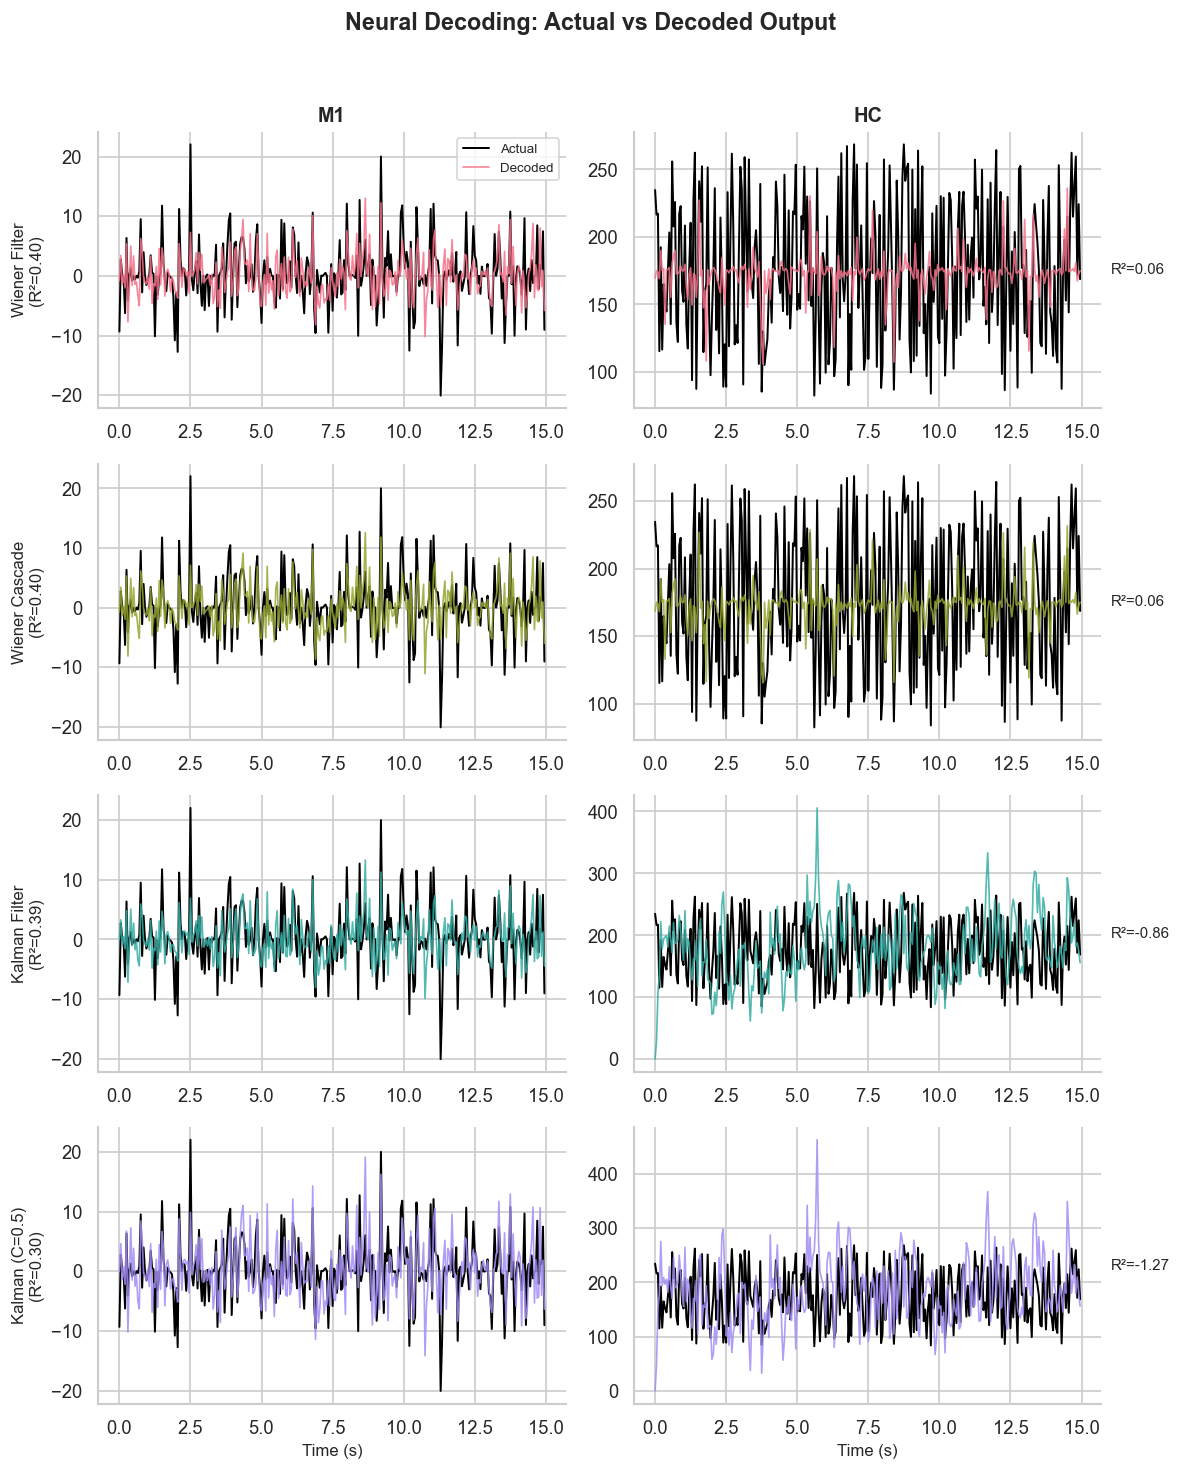

In [5]:
# Plot configuration
output_dim = 0  # Which output dimension to plot (0 = first)
time_window = slice(0, 300)  # Time samples to display (adjust as needed)

# Colors for each model
model_colors = sns.color_palette("husl", n_colors=len(model_names))
color_map = dict(zip(model_names, model_colors))

n_models = len(model_names)
n_datasets = len(dataset_names)

fig, axes = plt.subplots(
    n_models, n_datasets,
    figsize=(5 * n_datasets, 3 * n_models),
    sharex=False,
    sharey=False,
)

for row_idx, model_name in enumerate(model_names):
    for col_idx, ds_name in enumerate(dataset_names):
        ax = axes[row_idx, col_idx] if n_models > 1 else axes[col_idx]

        res = results[ds_name][model_name]
        y_true = res["y_test"][time_window, output_dim]
        y_pred = res["y_pred"][time_window, output_dim]
        time_axis = np.arange(len(y_true)) * bin_size

        # Plot actual (black) and predicted (color)
        ax.plot(time_axis, y_true, color="black", linewidth=1.2, label="Actual")
        ax.plot(time_axis, y_pred, color=color_map[model_name], linewidth=1.0, alpha=0.85, label="Decoded")

        # Compute R² for title
        r2_val = float(np.atleast_1d(res["metrics"]["r2"])[output_dim])

        # Labels and titles
        if row_idx == 0:
            ax.set_title(f"{ds_name}", fontsize=12, fontweight="bold")
        if col_idx == 0:
            ax.set_ylabel(f"{model_name}\n(R²={r2_val:.2f})", fontsize=10)
        else:
            ax.text(1.02, 0.5, f"R²={r2_val:.2f}", transform=ax.transAxes, fontsize=9, va="center")

        if row_idx == n_models - 1:
            ax.set_xlabel("Time (s)", fontsize=10)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Legend only on first subplot
        if row_idx == 0 and col_idx == 0:
            ax.legend(loc="upper right", fontsize=8)

fig.suptitle("Neural Decoding: Actual vs Decoded Output", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Save Figure

In [6]:
output_dir = project_root / "reports" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
fig_path = output_dir / "model_comparison_grid.png"
fig.savefig(fig_path, dpi=150, bbox_inches="tight")
print(f"Figure saved to {fig_path}")

Figure saved to /Users/kidus/Desktop/Neural_Decoding/Neural_Decoding_DS_Final/reports/figures/model_comparison_grid.png


## Summary Table

In [10]:
import pandas as pd

summary_rows = []
for ds_name in dataset_names:
    for model_name in model_names:
        metrics = results[ds_name][model_name]["metrics"]
        r2 = float(np.mean(np.atleast_1d(metrics["r2"])))
        rho = float(np.mean(np.atleast_1d(metrics["pearson_correlation"])))
        summary_rows.append({"Dataset": ds_name, "Model": model_name, "R²": r2, "Correlation": rho})

summary_df = pd.DataFrame(summary_rows)
summary_df.style.format({"R²": "{:.3f}", "Correlation": "{:.3f}"})

AttributeError: The '.style' accessor requires jinja2

In [11]:
# Display the results (simple print, no jinja2 required)
print(summary_df.round(3).to_string(index=False))

Dataset          Model     R²  Correlation
     M1  Wiener Filter  0.424        0.651
     M1 Wiener Cascade  0.427        0.654
     M1  Kalman Filter  0.420        0.648
     M1 Kalman (C=0.5)  0.343        0.648
     HC  Wiener Filter  0.086        0.289
     HC Wiener Cascade  0.091        0.297
     HC  Kalman Filter -0.508        0.106
     HC Kalman (C=0.5) -0.795        0.135
